In [95]:
import numpy as np 
import pandas as pd
import pickle, glob, os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings("ignore")

In [96]:
place = 'Keelung'
year = 2023

stages= 4 if year == 2023 else 3
file = glob.glob(f'../Results/soundsepration/{place}-5min/*_{year}*{stages}stage_separation/{place}_S1_cluster_nostd.csv')[0]
print(file)
savepath = file.rsplit('/', 1)[0]
df = pd.read_csv(file)

df_datetime = pd.DataFrame({'Datetime': [datetime.fromtimestamp(t) for t in df['Time'] ]} )
df = pd.concat([df,df_datetime], axis=1)
# df = df[~df['S1_Cluster'].isna()]

../Results/soundsepration/Keelung-5min/20240125_160851_2023_4stage_separation/Keelung_S1_cluster_nostd.csv


In [97]:
df_ = df.filter(regex='Cluster')
# S1_total, S3_total = [np.max(df_[key]) for key in df_.keys() ]
S1_total = [np.max(df_[key]) for key in df_.keys() ][0]
total_cluster = int(sum([ np.max(df_[key]) for key in df_.keys() ]))
# print(S1_total, S3_total)
print(total_cluster)

7


In [98]:
datelist = []

spec = defaultdict(list)
# spec = {'S1_1':[],
#        'S1_2': [],
#        'S1_3': [],
#        'S1_4': [],
#        'S3_1': [],
#        'S3_2': [],
#        'S3_3': []}

month = df['Datetime'][0].month
day = df['Datetime'][0].day
datezero = datetime(year, month, day, 0, 0, 0)
date = datetime(year, month, day, 23, 59, 0)

for dd in range(280):
    for hh in [23]:
        df_temp = df[df['Datetime'] < datetime(year, date.month, date.day, hh, 59, 0)][df['Datetime'] >= datetime(year, date.month, date.day, 0, 0, 0)]

        if len(df_temp[~df_temp['S1_Cluster'].isna()]) != 0: 

            df_temp_s1 = df_temp['S1_Cluster']
            # df_temp_s3 = df_temp['S3_Cluster']

            df_temp_c1 = set(df_temp_s1)
            # df_temp_c3 = set(df_temp_s3)

            for cc in range(1, int(S1_total)+1):
                spec[f'S1_{cc}'].append(df_temp_s1.to_list().count(cc)) 
            # for cc in range(1, int(S3_total)+1):
                # spec[f'S3_{cc}'].append(df_temp_s3.to_list().count(cc))     
        else:
            for cc in range(1, int(S1_total)+1):
                spec[f'S1_{cc}'].append(np.nan)
            # for cc in range(1, int(S3_total)+1):
                # spec[f'S3_{cc}'].append(np.nan)
        datelist.append(datetime(year, date.month, date.day, hh))
    date = date + timedelta(days = 1) 
    
df_spec = pd.DataFrame(spec)

In [99]:
date

datetime.datetime(2024, 1, 22, 23, 59)

In [100]:
sumlist = df_spec.sum(min_count=1, axis=1)
dp = pd.DataFrame(np.array([((df_spec.values[i:i+1]).tolist()[0]/ sumlist.values[i]).tolist()  for i in range(len(df_spec))] ))
# p_log = dp*np.log10(dp)
p_log = dp*np.log(dp)
H = -1*np.sum(p_log, axis=1)
H = [h  if h != -0.000000 else np.nan for h in H ]
df_H = pd.concat([pd.DataFrame({'Time':datelist, 'H': H}) ])

In [101]:
df_spec

,S1_1,S1_2,S1_3,S1_4,S1_5,S1_6,S1_7
0,71.0,0.0,0.0,0.0,3.0,62.0,4.0
1,125.0,0.0,0.0,0.0,7.0,156.0,0.0
2,150.0,0.0,0.0,0.0,4.0,133.0,1.0
3,131.0,4.0,0.0,0.0,8.0,141.0,4.0
4,139.0,0.0,0.0,0.0,15.0,133.0,1.0
...,...,...,...,...,...,...,...
275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,NaN,NaN,NaN,NaN


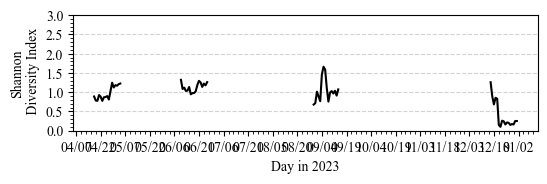

In [102]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 1.5))

plt.grid(axis='y', ls='--', color='lightgrey')

plt.plot(df_H['Time'], df_H['H'], 'k' )
last_index = df_H['H'][df_H['H'].isna() == False].index[-1]
# plt.xlim(df_H['Time'][0], df_H['Time'][last_index])
# plt.xlim(datetime(2023,6,10), datetime(2023,6,26))
plt.ylabel('Shannon\n Diversity Index')
plt.ylim(0, 3)

plt.xlabel(f'Day in {year}')
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

# plt.savefig('qqq.png', dpi=150)
df_H.to_csv(f'{savepath}/{place}_{year}_index_variations.csv', index=False)
plt.savefig(f'{savepath}/{place}_{year}_index_variations.png', dpi=150, bbox_inches='tight' )
plt.savefig(f'{savepath}/{place}_{year}_index_variations.pdf', dpi=150, bbox_inches='tight' )

In [103]:
def stats_plot(data, index, ax, year=2021, savepath=None):
    Q1 = round(np.nanpercentile(data, 25, interpolation = 'midpoint'), 3)
    Q2 = round(np.nanmedian(data),3)
    Q3 = round(np.nanpercentile(data, 75, interpolation = 'midpoint'), 3)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    
    upper_idx = data>=upper_bound
    lower_idx = data<=lower_bound

    if len(np.where(lower_idx)[0]) == 0 and len(np.where(upper_idx)[0]) == 0:
        drop_num = [np.nan]
    else:
        # print(f'origin Q: {Q1}, {Q2}, {Q3}')
        print('dropping ....')

        drop_num = [data.loc[i] for i in np.where(lower_idx)[0]] 
        for j in [data.loc[i] for i in np.where(upper_idx)[0]]:
            drop_num.append(j)
        
        data = data.drop(np.where(lower_idx)[0])
        data = data.drop(np.where(upper_idx)[0])

        
        Q1 = round(np.nanpercentile(data, 25, interpolation = 'midpoint'),3)
        Q2 = round(np.nanmedian(data),3)
        Q3 = round(np.nanpercentile(data, 75, interpolation = 'midpoint'),3)
    
    
    ax.plot([index, index], [np.nanmin(data), np.nanmax(data)], lw=2, color='r')
    ax.plot([index, index], [Q1, Q3], lw=7, color='r')
    ax.plot([index], [Q2], marker='o', markersize = 7, color='white', mec='k', mew=1.5)# ,edgecolors='k', lw=2
    ax.text(index+0.05, Q2, float("{:.2f}".format(Q2,2)), ha='left', va ='top', fontsize=8)
    
    if not drop_num[0] is np.nan:
        ax.scatter([index]*len(drop_num), drop_num,  marker='o', s=5, color='white', edgecolors='r', lw=2, alpha=0.2)
    
    print(index, Q1, Q2, Q3, drop_num, np.nanmin(data), np.nanmax(data))
    
    if not os.path.isfile(f'{savepath}/stats.log'):
        minn = np.nanmin(data)
        maxx = np.nanmax(data)
        cmd = ''' 
        echo year,index,Q1,Q2,Q3,min,max,drop > %(savepath)s/stats.log
        echo %(year)i,%(index)i,%(Q1)f,%(Q2)f,%(Q3)f,%(minn)f,%(maxx)f,%(drop_num)s >> %(savepath)s/stats.log
        '''%locals()
    else:
        minn = np.nanmin(data)
        maxx = np.nanmax(data)
        cmd = ''' 
        echo %(year)i,%(index)i,%(Q1)f,%(Q2)f,%(Q3)f,%(minn)f,%(maxx)f,%(drop_num)s >> %(savepath)s/stats.log
        '''%locals()        
    os.system(cmd)
    print()
    return Q1, Q2, Q3, drop_num, ax

1 0.872 0.913 1.176 [nan] 0.7751368345870131 1.3222766141575601

2 1.028 1.127 1.206 [nan] 0.9462512577004125 1.2948558668264447

dropping ....
3 0.826 0.979 1.034 [1.6621568509906148, 1.5915419036622103] 0.6791932659915256 1.458554734728336

4 0.162 0.243 0.684 [nan] 0.10126481756679193 1.2591663602333563



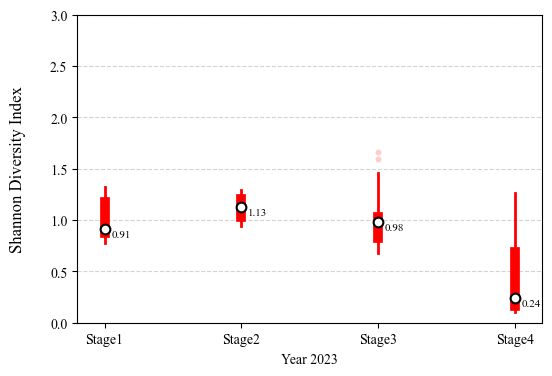

In [104]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
stage1 = df_H[df_H['Time']<datetime(year, 6, 10)]
Q1, Q2, Q3, drop_num, ax = stats_plot(stage1['H'], 1, ax, year=year, savepath=savepath)

stage2 = df_H[df_H['Time']>datetime(year, 6, 10)][df_H['Time']<datetime(year, 7, 30)]
stage2 = stage2.reset_index()
Q1, Q2, Q3, drop_num, ax = stats_plot(stage2['H'], 2, ax, year=year, savepath=savepath)

stage3 = df_H[df_H['Time']>datetime(year, 7, 30)][df_H['Time']<datetime(year, 10, 1)]
stage3 = stage3.reset_index()
Q1, Q2, Q3, drop_num, ax = stats_plot(stage3['H'], 3, ax, year=year, savepath=savepath)

if year == 2023:
    stage4 = df_H[df_H['Time']>datetime(year, 10, 1)]
    stage4 = stage4.reset_index()
    Q1, Q2, Q3, drop_num, ax = stats_plot(stage4['H'], 4, ax, year=year, savepath=savepath)


plt.ylim(0, 3)
if year == 2023:
    plt.xlim(0.8, 4.2)
    plt.xticks(range(1, 5), ['Stage1', 'Stage2', 'Stage3', 'Stage4'])
else:
    plt.xlim(0.8, 3.2)
    plt.xticks(range(1, 4), ['Stage1', 'Stage2', 'Stage3'])
plt.xlabel(f'Year {year}')

plt.grid(axis='y', ls='--', color='lightgrey')
plt.ylabel('Shannon Diversity Index\n', fontsize=12)

plt.savefig(f'{savepath}/{place}_{year}_index_stats.png', dpi=150 )
plt.savefig(f'{savepath}/{place}_{year}_index_stats.pdf', dpi=150 )